   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>

  * Distributed under the terms of the GPL License
  * Maintainer: dcline@mbari.org
  * Authors: Danelle Cline dcline@mbari.org, John Ryan ryjo@mbari.org

## Kernel Selection

If running in SageMaker, the Python 3 (Data Science) kernel is sufficient.
The Python 3 (TensorFlow 2.3 Python 3.7 GPU Optimized) will run the inference code faster for a higher cost.  For more advanced users,
[SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html)
is recommended to process data in bulk.

## Applying Machine Learning to classify blue whale A calls

---
Essential to detection and classification of marine mammal vocalizations are the distinct acoustic attributes of those vocalizations.   Machine learning (ML) is an effective way to recognize acoustic attributes and reliably classify such vocalizations.

In this brief tutorial, we will:
* tap into an extensive (6+ years and growing) archive of sound recordings from a deep-sea location [along the eastern margin of the North Pacific Ocean](https://www.mbari.org/at-sea/cabled-observatory/),
* illustrate the beautiful songs produced by baleen whales, and
* demonstrate the application of ML to classify one of the three types of calls produced by blue whales in their songs.

If you use this data set or tutorial, please [cite our project](https://ieeexplore.ieee.org/document/7761363)[1].

## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [15]:
!apt-get update -y && apt-get install -y libsndfile1
!python -m pip install --upgrade pip
!pip install tensorflow==2.4.1 --quiet
!pip install boto3 --quiet
!pip install oceansoundscape  --quiet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency 

### Import all packages

In [16]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import cv2
from oceansoundscape.spectrogram.signal import psd_1sec
from oceansoundscape.raven import BLEDParser
from oceansoundscape.spectrogram import conf, denoise, utils
import os
from pathlib import Path
import soundfile as sf
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.patches import Rectangle

## Why use 2 kHz data?

Because we are studying the low-frequency calls of blue whales, we don't need the original recordings sampled at 256 kHz.  Instead, we will use the 2 kHz decimated data in [WAV](https://en.wikipedia.org/wiki/WAV) format; these are stored in an s3 bucket named <b>pacific-sound-2khz</b>. For more information on the storage and organization of the 2kHz data, please see the [2kHz example](https://docs.mbari.org/pacific-sound/notebooks/PacificSound_2kHz/).

## List the contents of a monthly directory

Between August 2015 and July 2021 (a 6-year period), the highest levels of blue whale song activity off central California were detected during November 2017.  Let's start by listing the daily 2 kHz files for that month.

In [17]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))

year = 2017
month = 11
bucket = 'pacific-sound-2khz'

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year:04d}/{month:02d}')['Contents']:
    print(obj['Key'])

2017/11/MARS-20171101T000000Z-2kHz.wav
2017/11/MARS-20171102T000000Z-2kHz.wav
2017/11/MARS-20171103T000000Z-2kHz.wav
2017/11/MARS-20171104T000000Z-2kHz.wav
2017/11/MARS-20171105T000000Z-2kHz.wav
2017/11/MARS-20171106T000000Z-2kHz.wav
2017/11/MARS-20171107T000000Z-2kHz.wav
2017/11/MARS-20171108T000000Z-2kHz.wav
2017/11/MARS-20171109T000000Z-2kHz.wav
2017/11/MARS-20171110T000000Z-2kHz.wav
2017/11/MARS-20171111T000000Z-2kHz.wav
2017/11/MARS-20171112T000000Z-2kHz.wav
2017/11/MARS-20171113T000000Z-2kHz.wav
2017/11/MARS-20171114T000000Z-2kHz.wav
2017/11/MARS-20171115T000000Z-2kHz.wav
2017/11/MARS-20171116T000000Z-2kHz.wav
2017/11/MARS-20171117T000000Z-2kHz.wav
2017/11/MARS-20171118T000000Z-2kHz.wav
2017/11/MARS-20171119T000000Z-2kHz.wav
2017/11/MARS-20171120T000000Z-2kHz.wav
2017/11/MARS-20171121T000000Z-2kHz.wav
2017/11/MARS-20171122T000000Z-2kHz.wav
2017/11/MARS-20171123T000000Z-2kHz.wav
2017/11/MARS-20171124T000000Z-2kHz.wav
2017/11/MARS-20171125T000000Z-2kHz.wav
2017/11/MARS-20171126T000

## A view of baleen whale song

Let's produce a spectrogram with sufficient resolution in time and frequency to see the blue whale song with enough resolution to visually identify.  We'll limit the exercise to a single hour from a day with calls of variable received intensity (signal strength).

### Download a single 2 kHz file

In [18]:
year = 2017
month = 11
wav_filename = 'MARS-20171101T000000Z-2kHz.wav'
bucket = 'pacific-sound-2khz'
key = f'{year:04d}/{month:02d}/{wav_filename}'

s3 = boto3.resource('s3',
    aws_access_key_id='',
    aws_secret_access_key='',
    config=Config(signature_version=UNSIGNED))
 
# only download if needed
if not Path(wav_filename).exists():

    # Alternatively, it can be downloaded directly in SageMaker with
    # !aws s3 cp s3://{bucket}/{key} . 

    print('Downloading') 
    s3.Bucket(bucket).download_file(key, wav_filename)
    print('Done') 

### Subset to the 5th hour of the day

In [19]:
sample_rate = int(2e3)
start_hour = 5
start_frame = int(sample_rate * start_hour * 3600)
duration_frames =  int(sample_rate* 3600)

pacsound_file = sf.SoundFile(wav_filename)
pacsound_file.seek(start_frame)
x = pacsound_file.read(duration_frames, dtype='float32')

### Plot the full 2 kHz spectrogram

Lots of biophony (sounds of ocean life) are represented in this spectrogram.  Humpback whale songs are dominant above ~ 100 Hz, while blue and fin whale songs are dominant below ~ 100 Hz.  The energy of blue whale A calls is largely between ~70 and 90 Hz (between the white dashed lines). 

For more details about creating a calibrated spectrogram, see the [2 kHz tutorial](https://docs.mbari.org/pacific-sound/notebooks/PacificSound_2kHz/).

Text(0.5, 1.0, 'Calibrated spectrum levels')

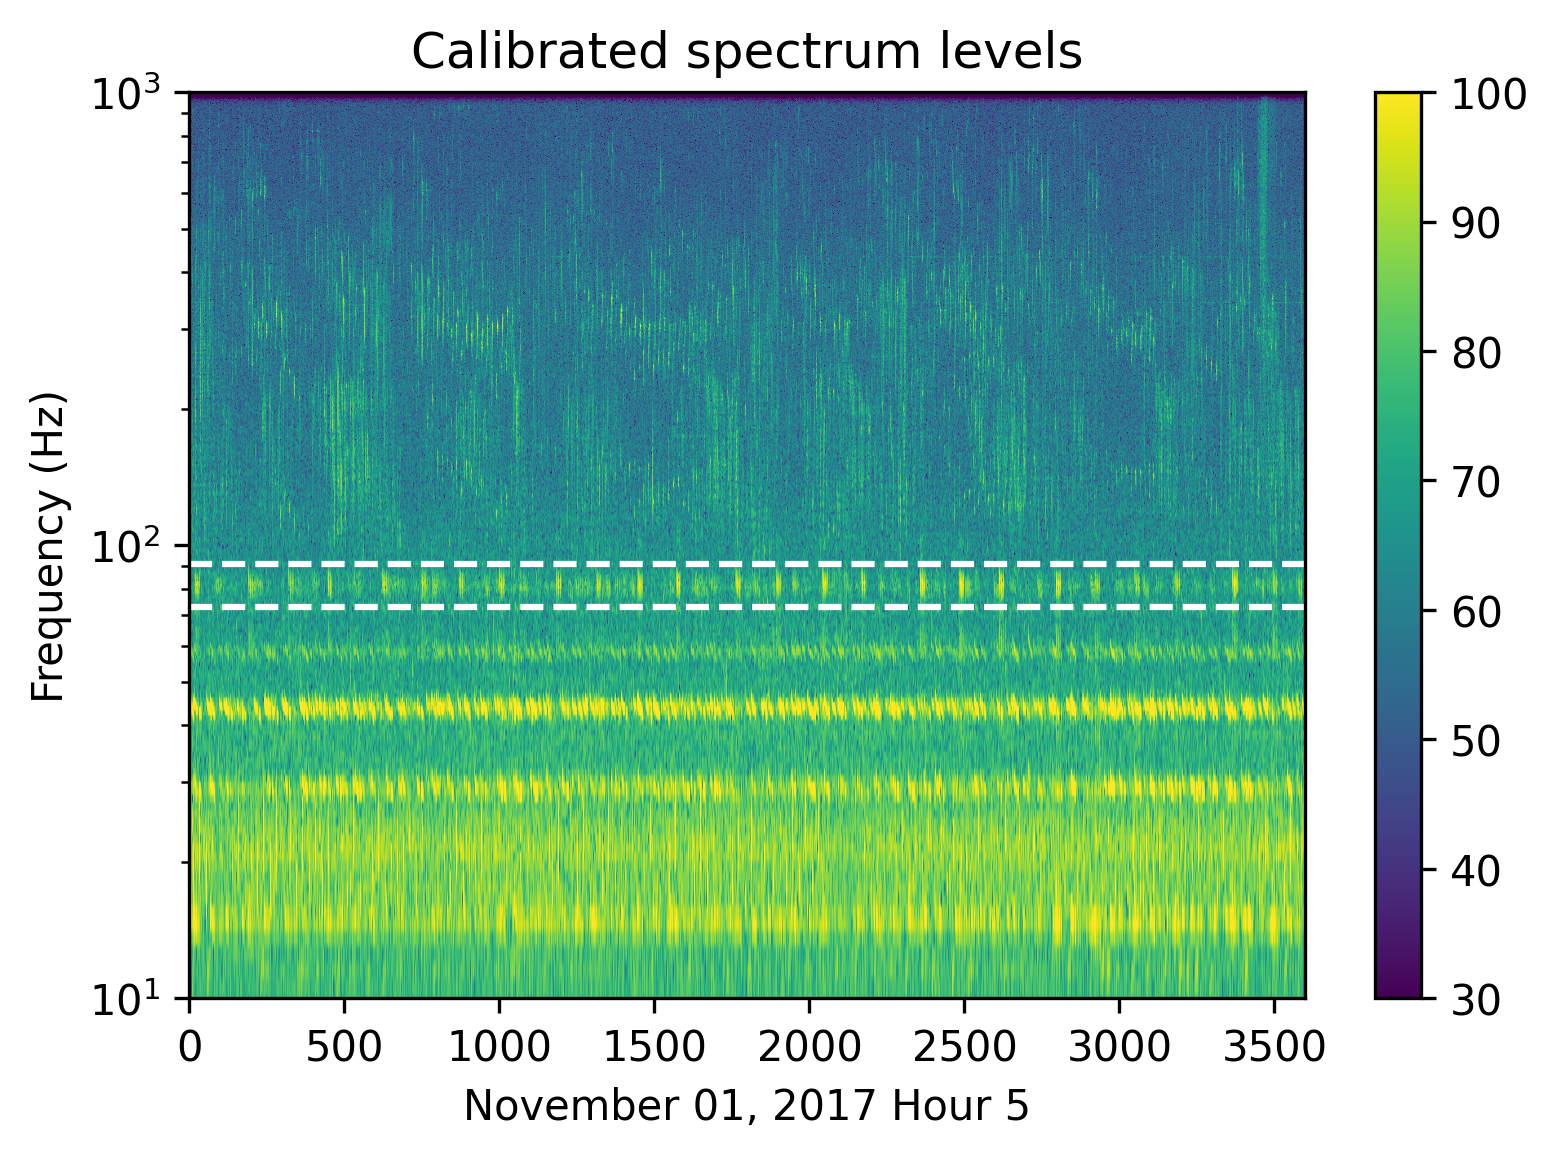

In [20]:
sg, f = psd_1sec(x, sample_rate, 177.9) # create calibrated psd
plt.figure(dpi=300)
plt.axhline(73,linestyle='--', color='white')
plt.axhline(91,linestyle='--', color='white')
plt.imshow(sg,extent=[0, 3600, min(f), max(f)],aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,1000)
plt.colorbar()
plt.xlabel('November 01, 2017 Hour 5')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')

###  Band Limited Energy Detections

In this example, we will focus on classification of calls.  Here, detections for potential Blue whale A calls
have been precomputed using Band-Limited-Energy-Detectors BLEDs in the [Raven](https://ravensoundsoftware.com) software. There are many way to do detection, including spectrogram correlation and neural network approaches such as single-shot detectors to name a few.  The best detector depends on the acoustic application and its cost/performance tradeoff.  

The approach taken here is to use the BLED detectors to identify not only strong and clear calls, but also many uncertain signals, so we can avoid missing calls.

An output from the BLED detectors might look something like this following simple table.

Note that this only represents a subset of the detections in the 5th hour for the purposes of this simple example.

In [21]:
bled_file = 'MARS-20171101T000000Z-2kHz.wav.Table01.txt'

In [22]:
%%writefile {bled_file}
Selection	View	Channel	Low Freq (Hz)	High Freq (Hz)	Begin Time (s)	End Time (s)
453	Spectrogram 1	1	70.0	90.0	19076.535750	19088.027750
454	Spectrogram 1	1	70.0	90.0	19115.990750	19132.331750
455	Spectrogram 1	1	70.0	90.0	19145.565750	19161.217750
456	Spectrogram 1	1	70.0	90.0	19182.693750	19200.880750
457	Spectrogram 1	1	70.0	90.0	19221.550750	19235.590750
458	Spectrogram 1	1	70.0	90.0	19244.183750	19270.027750
459	Spectrogram 1	1	70.0	90.0	19310.171750	19328.345750
460	Spectrogram 1	1	70.0	90.0	19342.502750	19360.689750
461	Spectrogram 1	1	70.0	90.0	19373.676750	19389.107750
462	Spectrogram 1	1	70.0	90.0	19398.727750	19410.193750
463	Spectrogram 1	1	70.0	90.0	19421.425750	19436.804750
464	Spectrogram 1	1	70.0	90.0	19445.189750	19461.803750
465	Spectrogram 1	1	70.0	90.0	19494.706750	19507.173750
466	Spectrogram 1	1	70.0	90.0	19527.622750	19538.555750
467	Spectrogram 1	1	70.0	90.0	19548.071750	19561.370750
468	Spectrogram 1	1	70.0	90.0	19568.377750	19585.186750
469	Spectrogram 1	1	70.0	90.0	19625.057750	19645.753750
470	Spectrogram 1	1	70.0	90.0	19653.293750	19676.381750
471	Spectrogram 1	1	70.0	90.0	19680.944750	19704.734750
472	Spectrogram 1	1	70.0	90.0	19708.543750	19723.051750
473	Spectrogram 1	1	70.0	90.0	19760.907750	19778.990750

Writing MARS-20171101T000000Z-2kHz.wav.Table01.txt


## Focus on blue whale A calls 

Zooming in on a more narrow frequency and time, we can see the pulse-train nature of the A calls, an important distinction for classification. In this brief segment, we can see A calls of variable received intensity.

Here, we parse the detections and display the identifying Raven Selection number for reference.

Notes: 
 * The first A call in this time period, which was quite strong, does not have a start marker because its start precedes the beginning of this audio segment. 
 * The full detail of the A calls is still not visible at the resolution presented above. The full detail will become clear when we apply the model and examine individual classified calls.

Reading MARS-20171101T000000Z-2kHz.wav.Table01.txt {'low_freq': 70, 'high_freq': 100, 'duration_secs': 25, 'blur_axis': 'frequency', 'num_fft': 1024, 'center': True, 'padding_secs': 3, 'num_mels': 30}
Found 21 detections in MARS-20171101T000000Z-2kHz.wav.Table01.txt


Text(0.5, 1.0, 'Detected blue whale A calls')

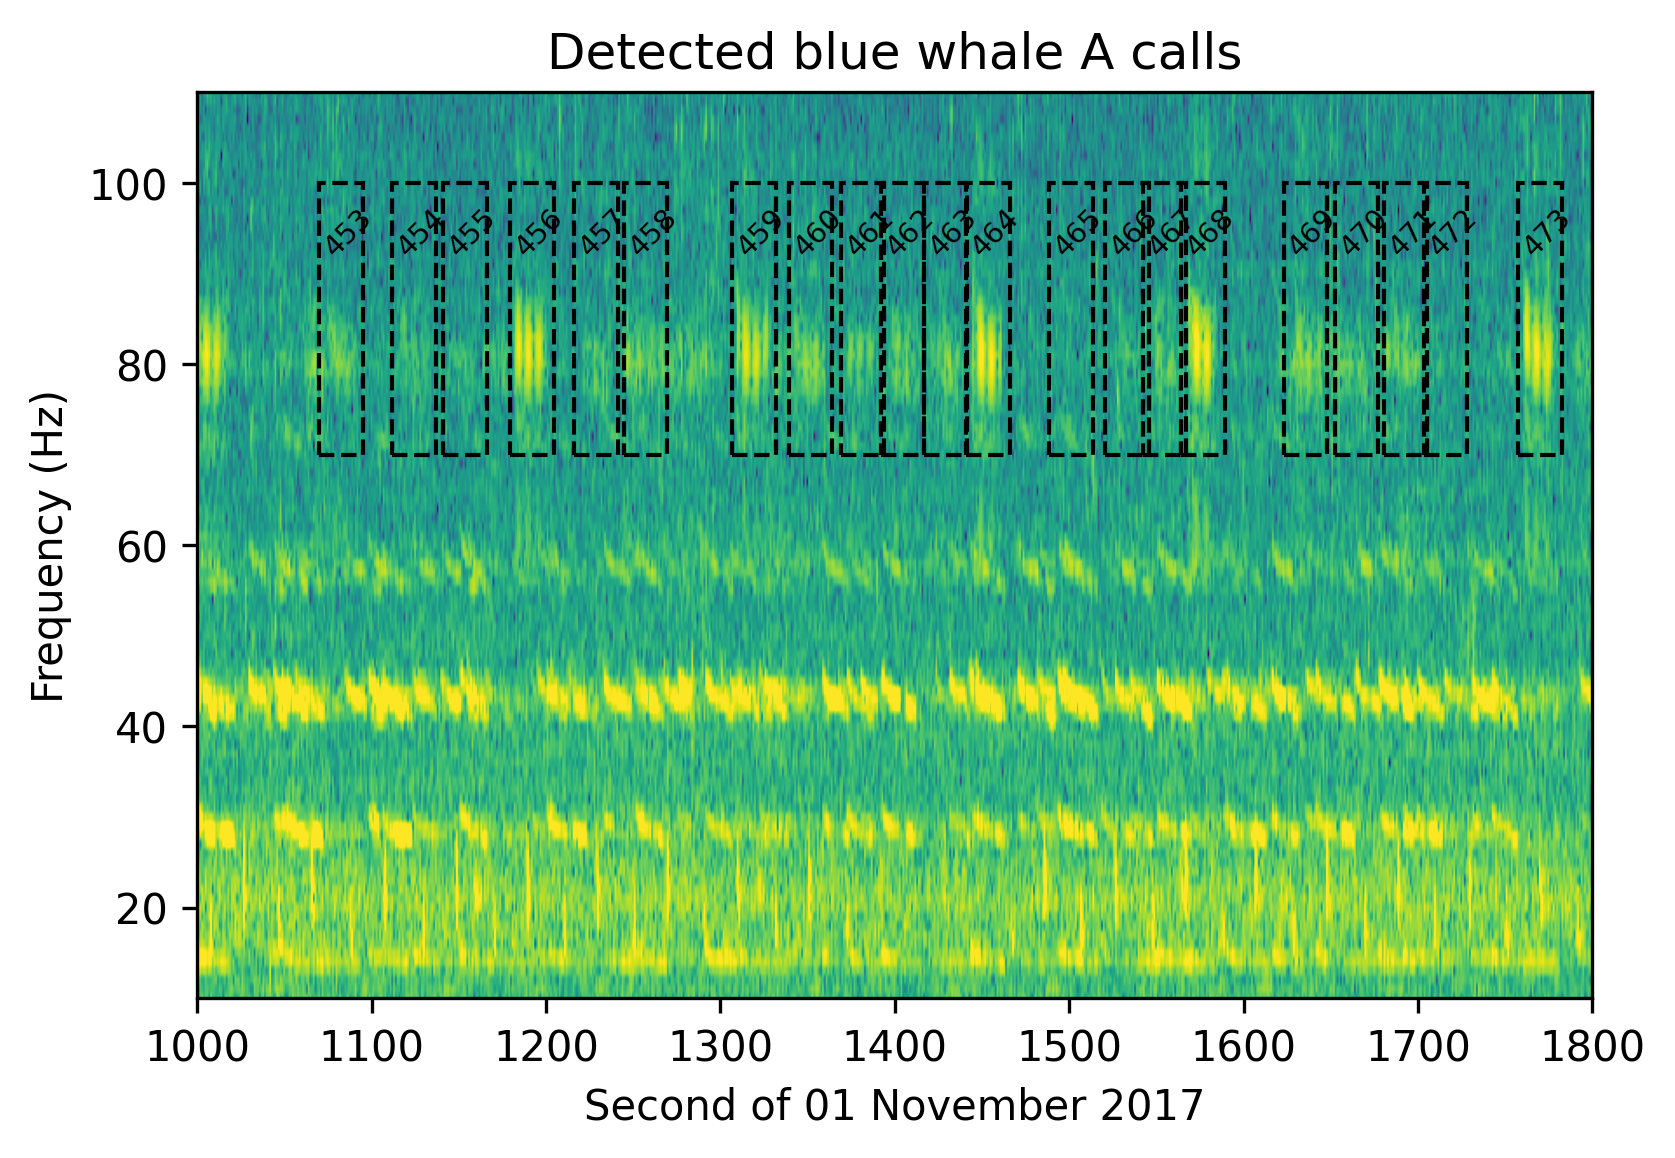

In [23]:
# an optimum configuration for the call spectrogram generation is defined in the oceanscoundscape package based on extensive
# hyper parameter sweeps. Let's grab those here
blue_a_conf = conf.CONF_DICT['blueA']

# BLEDParser needs a path object
bled_path = Path(bled_file)

# parse the detections
parser = BLEDParser(bled_path, blue_a_conf, max_samples=len(x), sampling_rate=sample_rate)

# plot the spectrogram
plt.figure(dpi=300)
plt.imshow(sg,aspect='auto',origin='lower',vmin=30,vmax=100)

# add boxes for each normalized detection - detections are normalized to a fixed size (frequency/time) for classification
start_secs = start_hour * 3600
high_freq = blue_a_conf['high_freq']
low_freq = blue_a_conf['low_freq']
duration_secs = blue_a_conf['duration_secs']
freq_window = int(high_freq - low_freq)
for row, item in sorted(parser.data.iterrows()):
    detection_start = item.call_start/sample_rate - start_secs # detections are stored in sample numbers so here we convert back to time
    plt.gca().add_patch(Rectangle((detection_start,low_freq),duration_secs,freq_window,
                        edgecolor='black',
                        facecolor='none',
                        ls='--',
                        lw=1))
    plt.text(detection_start,high_freq - 8,item.Selection, size='x-small', rotation=45)

plt.yscale('linear')
plt.ylim(10,high_freq + 10)
plt.xlim(1000, 1800)
plt.xlabel('Second of 01 November 2017')
plt.ylabel('Frequency (Hz)')
plt.title('Detected blue whale A calls')


## Classification of blue whale A calls

We can turn these detected audio signals into images, one for each detected signal, and classify them using a model trained for only A calls.


### Create optimized spectrograms

Because the model we are demonstrating is image based, the first step to classify the calls is to create optimized spectrograms for each candidate detection.

In [24]:
# read the wav file
xc, sample_rate = sf.read(wav_filename)
 
# parse the detections, but this time let's use the entire wav file to allow for padding during denoising
parser_full = BLEDParser(bled_path, blue_a_conf, len(xc), sample_rate)

# grab the spectrogram parameters
call_width = int(blue_a_conf['duration_secs'] * sample_rate)
num_fft = blue_a_conf['num_fft']
hop_length = round(num_fft * (1 - conf.OVERLAP))

# generate optimized spectrograms
print(f'Denoising {bled_file} num detections {parser_full.num_detections}')

# denoise them and store the results in a temporary hdf file cache
cache = denoise.PCENSmooth(Path(f'{bled_path}.hdf'), parser_full, blue_a_conf, xc, sample_rate)

for row, item in sorted(parser_full.data.iterrows()):
    try:
        start = int(call_width / hop_length)
        end = int(2 * call_width / hop_length)

        data = cache.get_data(item.Selection)

        # subset the call, leaving off the padding for PCEN
        subset_data = data[:, start:end]

        # save to a denoised color image
        utils.ImageUtils.colorizeDenoise(subset_data, Path(item.image_filename))
    except Exception as ex:
        print(ex)
        continue

print('Done')

Reading MARS-20171101T000000Z-2kHz.wav.Table01.txt {'low_freq': 70, 'high_freq': 100, 'duration_secs': 25, 'blur_axis': 'frequency', 'num_fft': 1024, 'center': True, 'padding_secs': 3, 'num_mels': 30}
Found 21 detections in MARS-20171101T000000Z-2kHz.wav.Table01.txt
Denoising MARS-20171101T000000Z-2kHz.wav.Table01.txt num detections 21
Done


### Display the spectrogram images

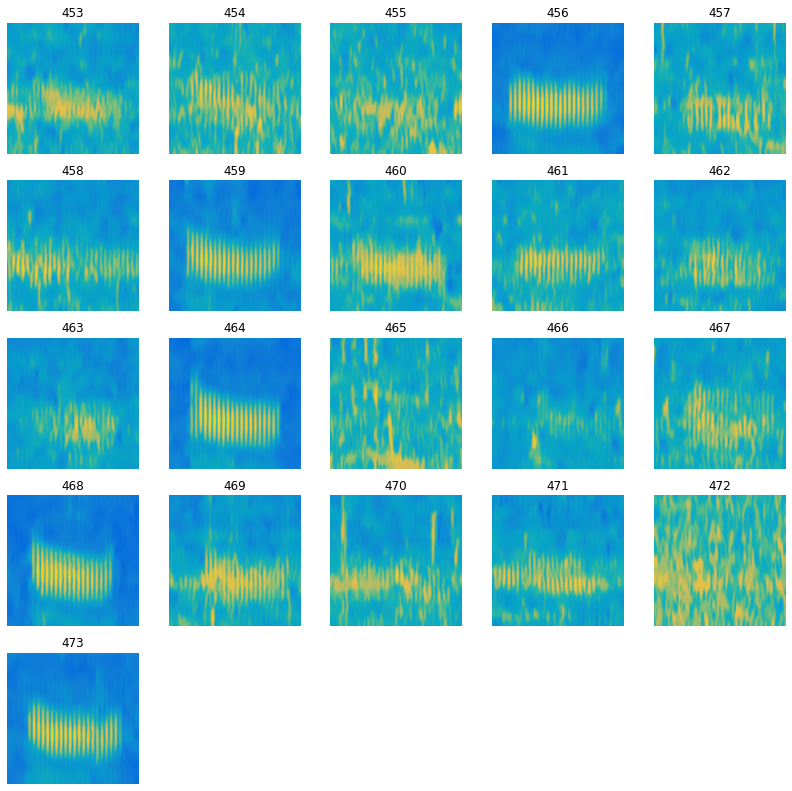

In [25]:
images = list( sorted((Path.cwd()).glob('*.jpg')))

plt.figure(figsize=(14,14))
plt.rcParams['axes.titlelocation'] = 'center'
for i, image_path in enumerate(images):
    # the selection number of part of the filename name,
    # e.g. selection 3 20150925T072604.53528828.53552892.sel.03.ch01.spectrogram.jpg
    selection = image_path.name.split('.')[4]
    image_path = str(image_path)
    plt.subplot(5, 5, i + 1)
    img = plt.imread(image_path)
    plt.title(selection)
    plt.imshow(img)
    plt.axis('off')

### Download the model

MBARI has a trained model that can be used to classify blue A calls.  You can find that model in the pacific-sound-models bucket.
More details on its performance can be found in the [pacific sound model page](http://docs.mbari.org/pacific-sound/models/).

First, download that model then uncompress it.  The model should be version 1 and exist in a subdirectory simply called "1".

In [26]:
bucket = 'pacific-sound-models'
model_filename = 'bluewhale-a-resnet50-2022-02-05-01-58-47-285.tar.gz'
key = model_filename

print(f'Downloading...') 
s3.Bucket(bucket).download_file(key, model_filename)

# Alternatively, it can be downloaded directly in SageMaker with
# !aws s3 cp s3://{bucket}/{key} . 

print(f'Uncompressing')
!tar -xf {model_filename}
print(f'Done')

Downloading...
Uncompressing
Done


In [27]:
os.listdir("1")

['saved_model.pb', 'config.json', 'assets', 'variables']

### Load the model weights

In [28]:
model = tf.keras.models.load_model("1")

### Show the model architecture and grab the normalization parameters

Here, we can see the last layer only this model only outputs a 2 wide vector - this is for either blue whale A false or blue whale A true calls.   Class labels are defined in the config.json with the model as are the normalization parameters.

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
config = json.load(open('1/config.json'))
image_mean = np.asarray(config["image_mean"])
image_std = np.asarray(config["image_std"])
print(f"Labels {config['classes']}")
print(f"Training image mean: {image_mean}")
print(f"Training image std: {image_std}")

Labels ['baf', 'bat']
Training image mean: [0.18747011 0.66276884 0.68202728]
Training image std: [0.03253593 0.01769102 0.01564376]


### Run the model on a single image

The model outputs an array with the scores between 0-1 for each class.  Let's run it on a single image of a strong A call just to verify it is working.  The output should be a 2-dimensional numpy array representing each class score.  These scores should sum to 1 and the output should be definitely a positive A call "bat" i.e. blue A true in the second index.

In [31]:
batch_size = 1
image_path =  '20171101T051942.38365387.38401761.sel.456.ch01.spectrogram.jpg'
image_bgr = cv2.imread(image_path)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# normalize with the same parameters used in training
image_float = np.asarray(image).astype('float32')
image_float = image_float / 255.
image_float = (image_float - image_mean) / ( image_std + 1.e-9)
image_stack = np.concatenate([image_float[np.newaxis, :, :]] * batch_size)
tensor_out = model(image_stack)
# convert the tensor to a numpy array and since this is just a batch size of 1, pull out the single
# prediction
p = tensor_out.numpy()[0]
print(p)

[0.00773171 0.99226826]


### Create a helper function to display the class names instead of just a score

predicted label bat score 0.9922682642936707


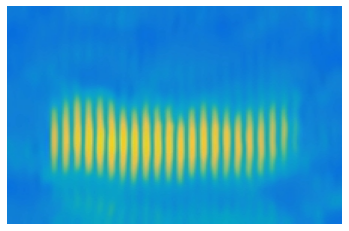

In [32]:
def prediction_to_labelscore(prediction: np.array(float)):
    # predictor outputs an index but we want to see the string, so let's map back
    # to the order the class labels are stored in the config
    label_map = {0: 'baf', 1: 'bat'}

    # get the index of the top score and its score
    top_score_index = np.argmax(prediction)
    top_score = prediction[top_score_index]
    label = label_map[top_score_index]
    return label, top_score

# let's test it with the output above on the single image
plt.imshow(image, aspect='auto')
plt.axis('off')
label, top_score = prediction_to_labelscore(p)
print(f'predicted label {label} score {top_score}')


### Classify all images

Now that we are confident the model runs okay on a single image, let's run it on all the spectrogram images and display them with their associated scores and capture the predictions in a dictionary to use later.

Running model on 20171101T051756.38153071.38176055.sel.453.ch01.spectrogram.jpg
Running model on 20171101T051835.38231981.38264663.sel.454.ch01.spectrogram.jpg
Running model on 20171101T051905.38291131.38322435.sel.455.ch01.spectrogram.jpg
Running model on 20171101T051942.38365387.38401761.sel.456.ch01.spectrogram.jpg
Running model on 20171101T052021.38443101.38471181.sel.457.ch01.spectrogram.jpg
Running model on 20171101T052044.38488367.38540055.sel.458.ch01.spectrogram.jpg
Running model on 20171101T052150.38620343.38656691.sel.459.ch01.spectrogram.jpg
Running model on 20171101T052222.38685005.38721379.sel.460.ch01.spectrogram.jpg
Running model on 20171101T052253.38747353.38778215.sel.461.ch01.spectrogram.jpg
Running model on 20171101T052318.38797455.38820387.sel.462.ch01.spectrogram.jpg
Running model on 20171101T052341.38842851.38873609.sel.463.ch01.spectrogram.jpg
Running model on 20171101T052405.38890379.38923607.sel.464.ch01.spectrogram.jpg
Running model on 20171101T052454.3898941

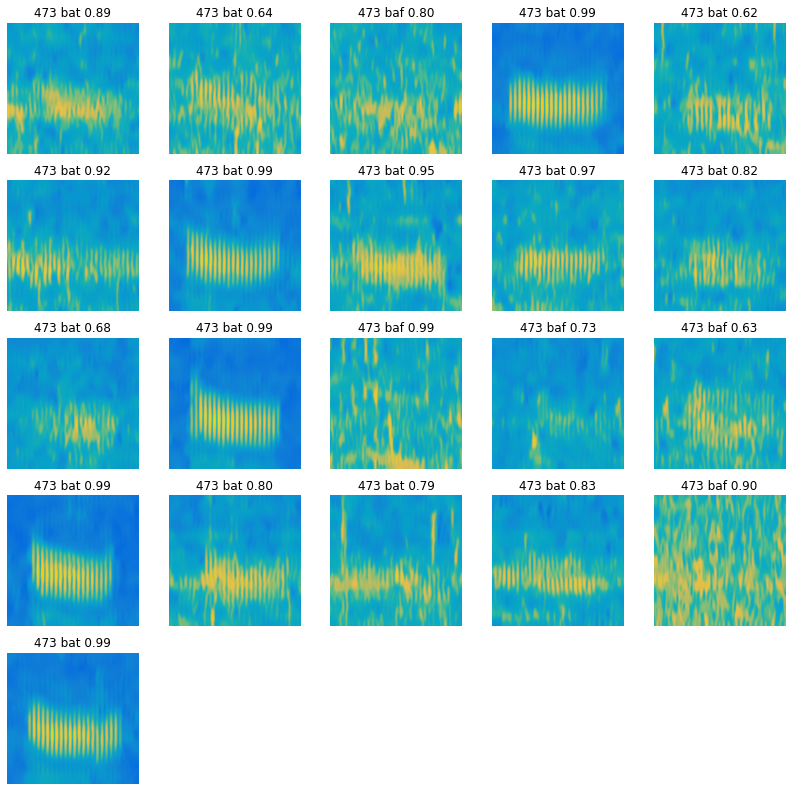

In [33]:
plt.figure(figsize=(14,14))
plt.rcParams['axes.titlelocation'] = 'center'
batch_size = 1
predictions = {}

for i, image_path in enumerate(images):
    print(f'Running model on {image_path.name}')
    image_bgr = cv2.imread(image_path.as_posix())
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_float = np.asarray(image).astype('float32')
    image_float = image_float / 255.
    image_float = (image_float - image_mean) / ( image_std + 1.e-9)
    image = np.concatenate([image_float[np.newaxis, :, :]] * batch_size)
    tensor_out = model(image)
    label, top_score = prediction_to_labelscore(tensor_out.numpy()[0])
    predictions[image_path.name] = {'class': label, 'score': top_score}
    plt.subplot(5, 5, i + 1)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f'{selection} {label} {top_score:0.2f}')
    plt.axis('off')

### Display confident classifications

Now that the classifications have been run on all the potential detections, let's see all true classifications in the 1-second spectrogram with scores greater then 0.7.

Text(0.5, 1.0, 'Classified blue whale A calls > 0.7 confidence')

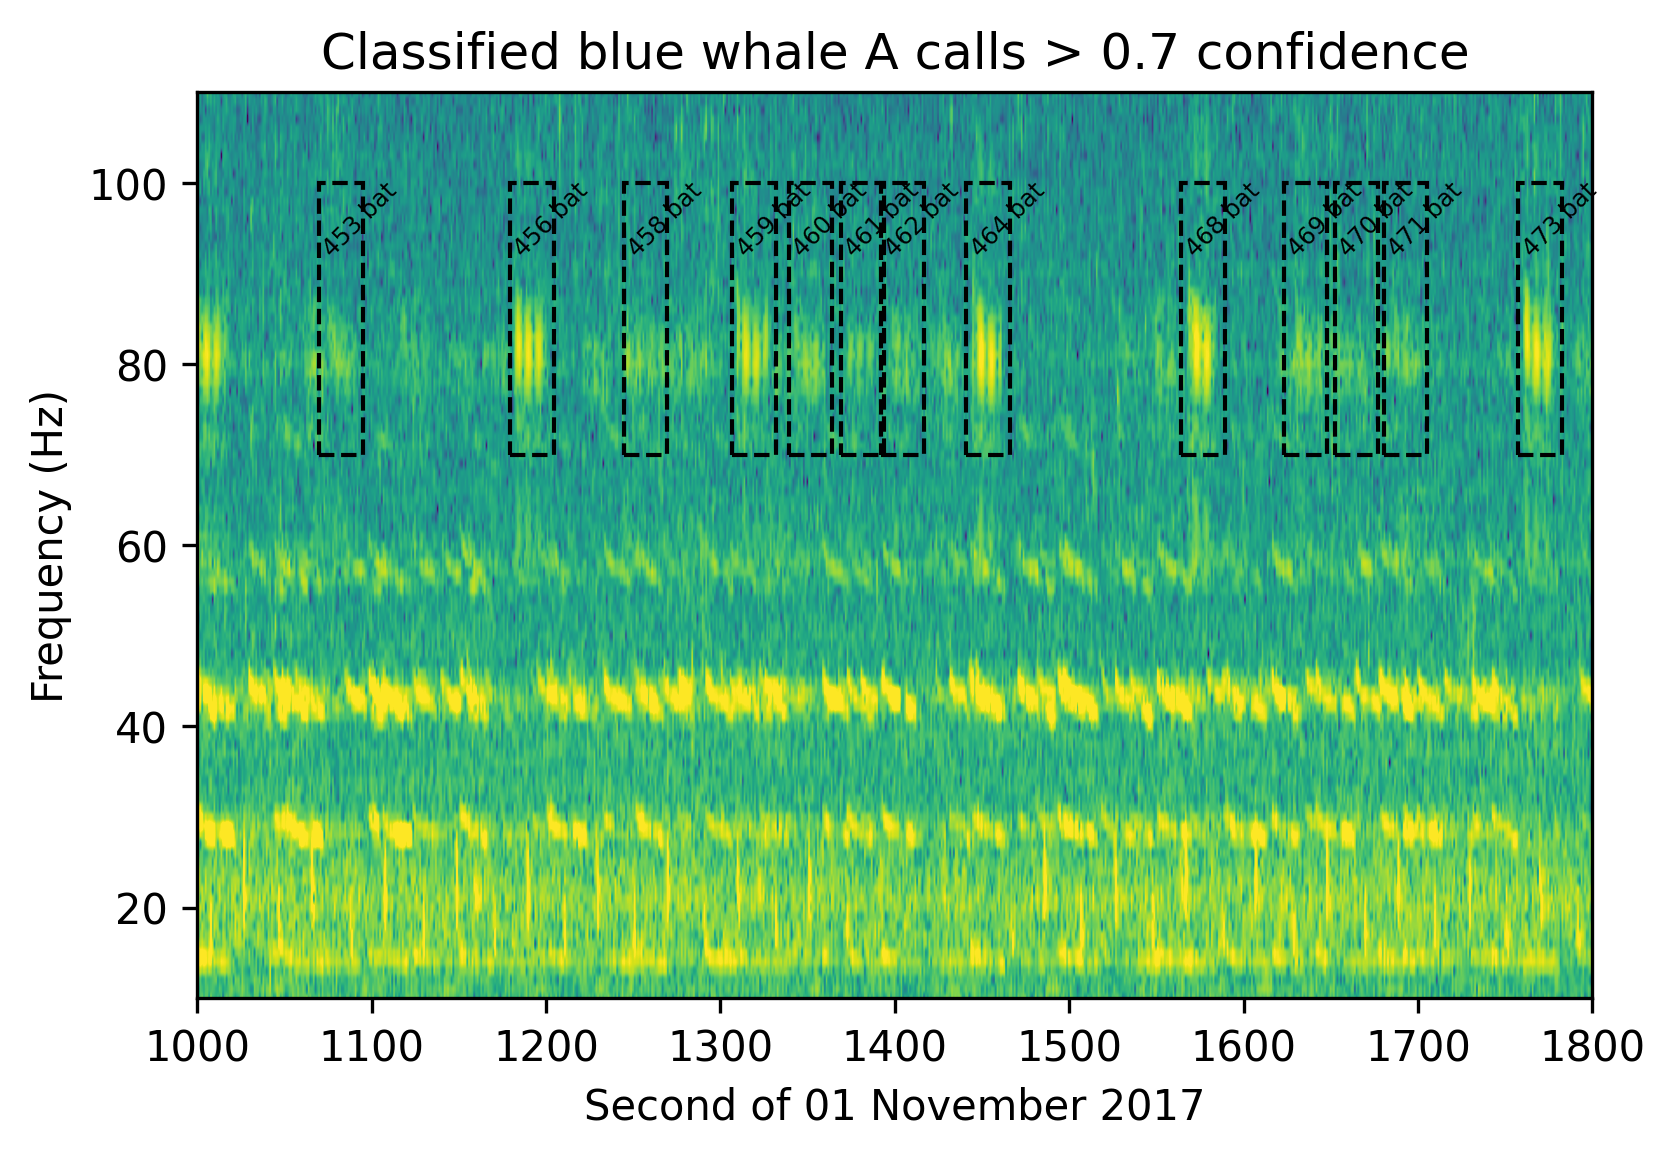

In [34]:
# plot the spectrogram
plt.figure(dpi=300)
plt.imshow(sg,aspect='auto',origin='lower',vmin=30,vmax=100)

# decorate with boxes for each normalized detection - detections are normalized to a fixed size (frequency/time) for classification
start_secs = 5 * 3600
high_freq = blue_a_conf['high_freq']
low_freq = blue_a_conf['low_freq']
duration_secs = blue_a_conf['duration_secs']
freq_window = int(high_freq - low_freq)
for row, item in sorted(parser.data.iterrows()):
    detection_start = item.call_start/sample_rate - start_secs # detections are stored in sample numbers so here we convert back to time
    p = predictions[item.image_filename]
    if p['score'] > 0.7 and p['class'] == 'bat':
        plt.gca().add_patch(Rectangle((detection_start,low_freq),duration_secs,freq_window,
                            edgecolor='black',
                            facecolor='none',
                            ls='--',
                            lw=1))
        plt.text(detection_start,high_freq - 8, f'{item.Selection} bat', size='xx-small', rotation=45)

plt.yscale('linear')
plt.ylim(10,high_freq + 10)
plt.xlim(1000, 1800)
plt.xlabel('Second of 01 November 2017')
plt.ylabel('Frequency (Hz)')
plt.title('Classified blue whale A calls > 0.7 confidence')

## References

- [1] https://doi.org/10.1109/OCEANS.2016.7761363